# QA-Model

### Imports

In [19]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, TrainingArguments, Trainer
from wordcloud import WordCloud
#import plotly.graph_objects as go
import pickle

### Load and explore the dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from the Hugging Face datasets library
dataset = load_dataset("toughdata/quora-question-answer-dataset")
train_data = dataset['train']
train_df = pd.DataFrame(train_data)

print(train_df.head())

train_df.to_csv('quora_question_answer_dataset.csv', index=False)


In [5]:

dataset = load_dataset('toughdata/quora-question-answer-dataset')
print(dataset)

# Check for the splits in the dataset
if 'validation' not in dataset:
    # Assuming the train split needs to be split into train and validation
    train_valid = dataset['train'].train_test_split(test_size=0.1)  # 10% of train data for validation
    dataset = DatasetDict({
        'train': train_valid['train'],
        'validation': train_valid['test']
    })
print(dataset)

# Assuming the correct columns are 'question' and 'answer_text'
question_col = 'question'  # Replace with actual column name if different
context_col = 'answer'  # Replace with actual column name if different

# Convert to pandas DataFrame
data = dataset['train'].to_pandas()

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 56402
    })
})
DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 50761
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 5641
    })
})


In [14]:
print(data.head())
print(data.info())
print(data.describe())
print(data.isnull().sum())


                                            question  \
0  What kind of food do people from the UK eat th...   
1  What is the difference between "perfume", "eau...   
2  Which rock band has had the most messed up/dys...   
3  What is the future of a web development compan...   
4  Without looking at a map, how well can you dra...   

                                              answer  
0  Haggis.\n And tea so strong that it’s undrinka...  
1  It's all about the concentration of fragrance ...  
2  Gotta be Spinal Tap. That thing with the drumm...  
3  future of a [LINKED_TEXT: web development comp...  
4  Hey! This is not Baphomet; it is my lovely mot...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50761 entries, 0 to 50760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  50761 non-null  object
 1   answer    50761 non-null  object
dtypes: object(2)
memory usage: 793.3+ KB
None
                          

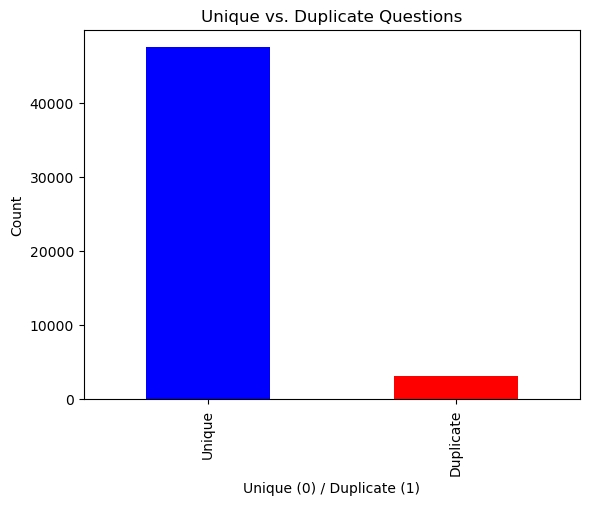

In [23]:
# Check for duplicate questions
data['question_duplicate'] = data.duplicated('question')

# Plot unique vs. duplicate
data['question_duplicate'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Unique vs. Duplicate Questions')
plt.xlabel('Unique (0) / Duplicate (1)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Unique', 'Duplicate'])
plt.show()


### Preprocess the data

In [24]:

data.drop_duplicates(inplace=True)

data.dropna(inplace=True)


import re

def clean_text(text):

    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip().lower()

data['processed_question1'] = data['question'].apply(clean_text)
data['processed_answer1'] = data['answer'].apply(clean_text)


In [25]:

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(examples):
    questions = examples[question_col]
    contexts = examples[context_col]
    inputs = tokenizer(questions, contexts, truncation=True, padding=True)
    return inputs

tokenized_dataset = dataset.map(preprocess_data, batched=True)


loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /Users/ronitsikri/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncase

Map:   0%|          | 0/5641 [00:00<?, ? examples/s]

### Model selection

In [12]:
model = AutoModelForQuestionAnswering.from_pretrained('bert-base-uncased')

/Users/ronitsikri_PRO/miniconda3/envs/main/lib/python3.10/site-packages/transformers/modeling_utils.py:349: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(c

### Training

In [13]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation']
)

# Train the model
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: question, answer. If question, answer are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
/Users/ronitsikri_PRO/miniconda3/envs/main/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 50761
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 9519

  0%|          | 0/9519 [00:00<?, ?it/s]


### Evaluation

In [ ]:
results = trainer.evaluate()
print(f"Evaluation results: {results}")

### Save the model

In [ ]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

## Visualizations

### Data Distribution

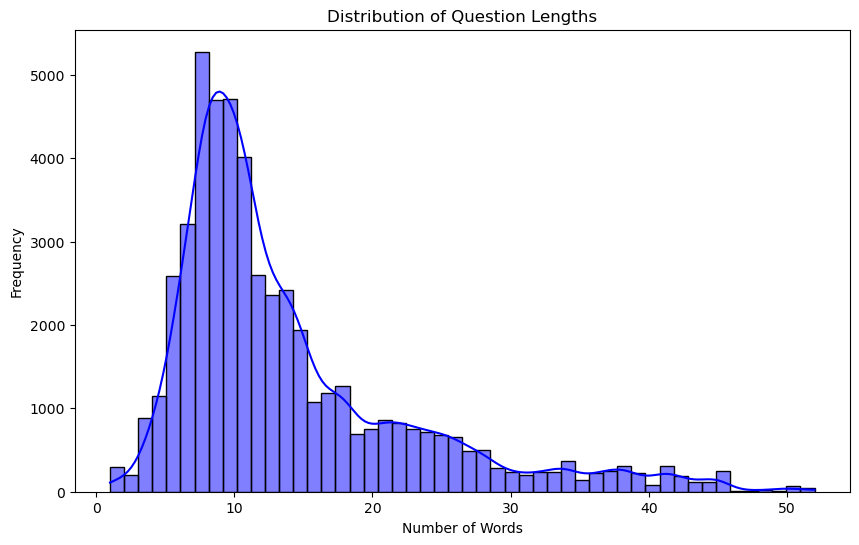

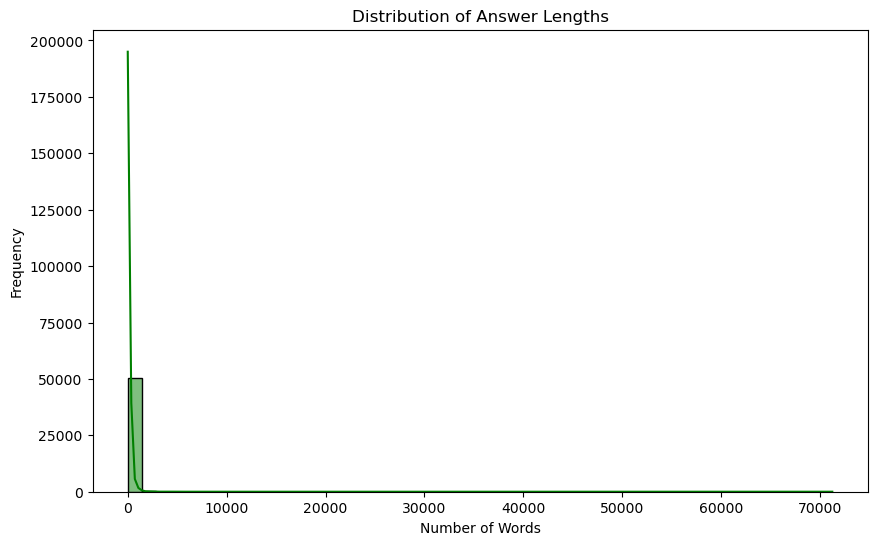

In [15]:
data['question_length'] = data[question_col].apply(lambda x: len(x.split()))
data['answer_length'] = data[context_col].apply(lambda x: len(x.split()))

# Plotting question length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['question_length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plotting answer length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['answer_length'], bins=50, kde=True, color='green')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### Feature Importance

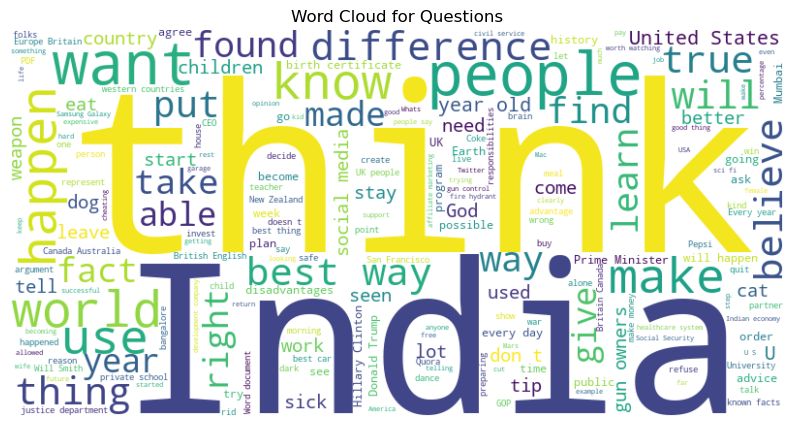

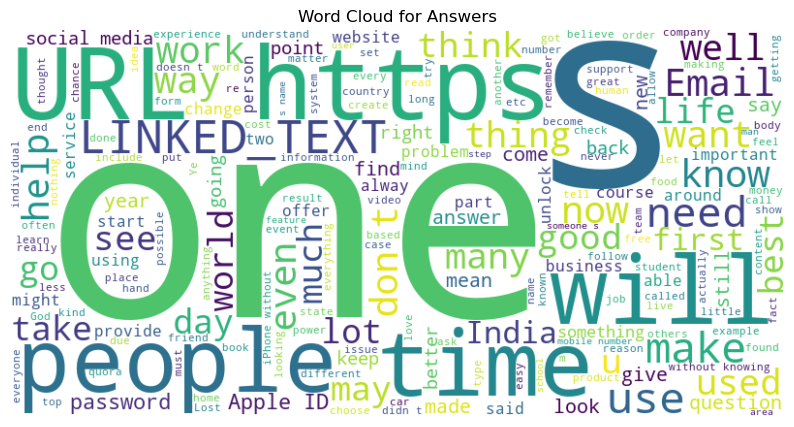

In [21]:
all_questions = ' '.join(data[question_col].tolist())
all_answers = ' '.join(data[context_col].tolist())

# Generate word cloud for questions
wordcloud_questions = WordCloud(width=800, height=400, background_color='white').generate(all_questions)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_questions, interpolation='bilinear')
plt.title('Word Cloud for Questions')
plt.axis('off')
plt.show()

# Generate word cloud for answers
wordcloud_answers = WordCloud(width=800, height=400, background_color='white').generate(all_answers)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_answers, interpolation='bilinear')
plt.title('Word Cloud for Answers')
plt.axis('off')
plt.show()

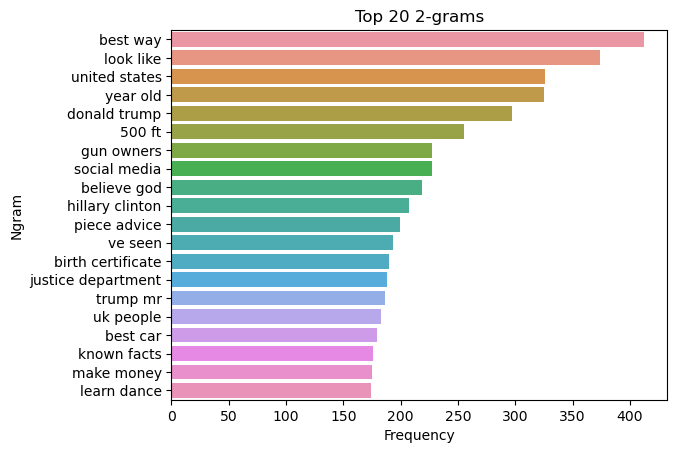

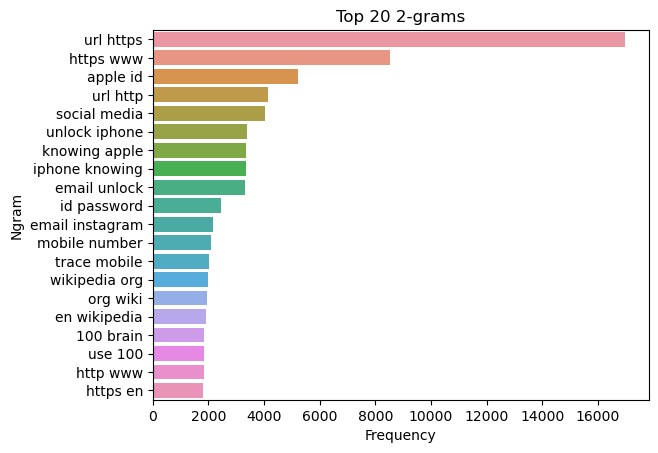

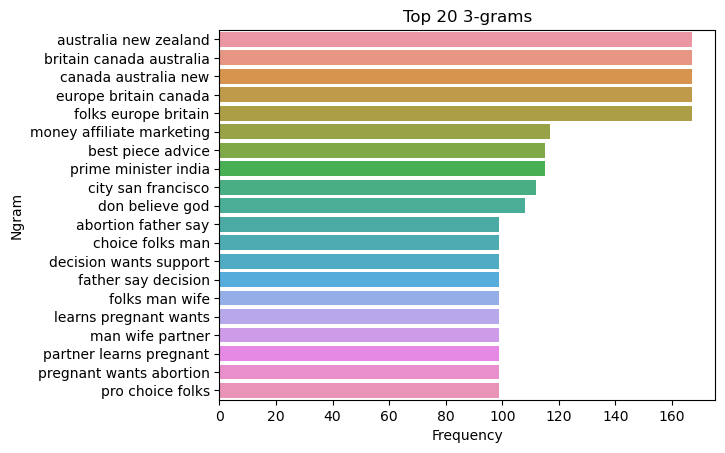

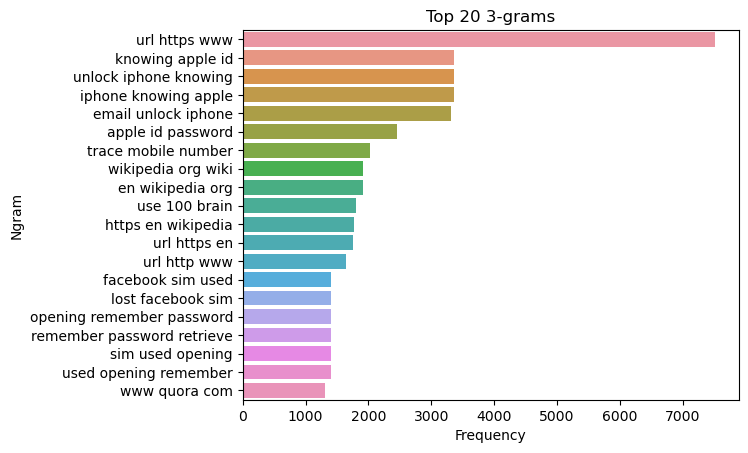

In [22]:
#N gram analysis
from sklearn.feature_extraction.text import CountVectorizer

def plot_ngrams(text_data, n=2, top_k=20):
    vectorizer = CountVectorizer(ngram_range=(n, n), stop_words='english')
    ngrams = vectorizer.fit_transform(text_data)
    ngram_counts = ngrams.sum(axis=0).A1
    ngram_vocab = vectorizer.get_feature_names_out()
    ngram_freq = Counter(dict(zip(ngram_vocab, ngram_counts)))
    common_ngrams = ngram_freq.most_common(top_k)

    ngram_df = pd.DataFrame(common_ngrams, columns=['Ngram', 'Frequency'])
    sns.barplot(data=ngram_df, x='Frequency', y='Ngram')
    plt.title(f'Top {top_k} {n}-grams')
    plt.show()

# Plot bigrams and trigrams
plot_ngrams(data['question'], n=2, top_k=20)
plot_ngrams(data['answer'], n=2, top_k=20)
plot_ngrams(data['question'], n=3, top_k=20)
plot_ngrams(data['answer'], n=3, top_k=20)


### Model Performance

In [ ]:

log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

# Plotting training loss and evaluation loss
fig = go.Figure()

fig.add_trace(go.Scatter(x=log_df['epoch'], y=log_df['loss'], mode='lines+markers', name='Training Loss'))
fig.add_trace(go.Scatter(x=log_df['epoch'], y=log_df['eval_loss'], mode='lines+markers', name='Evaluation Loss'))

fig.update_layout(
    title='Training and Evaluation Loss Over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss',
    legend_title='Loss Type',
    template='plotly_white'
)

fig.show()

# Plotting evaluation metrics like F1 score
if 'eval_f1' in log_df.columns:
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=log_df['epoch'], y=log_df['eval_f1'], mode='lines+markers', name='Evaluation F1 Score'))

    fig.update_layout(
        title='Evaluation F1 Score Over Epochs',
        xaxis_title='Epoch',
        yaxis_title='F1 Score',
        legend_title='Metric Type',
        template='plotly_white'
    )

    fig.show()
